<a href="https://colab.research.google.com/github/smallriver0316/python-datascience-study/blob/development/labeled_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# Labeled Faces in the Wild
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


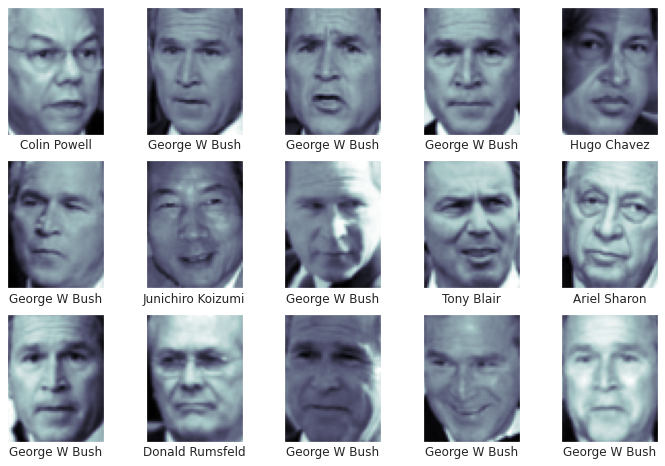

In [3]:
fig, ax = plt.subplots(3, 5, figsize=(12, 8))
for i, axi in enumerate(ax.flat):
  axi.imshow(faces.images[i], cmap='bone')
  axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

In [4]:
# 主成分分析によって、主要な成分を抽出
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

# 150の成分を抽出
# 元画像は62x47=2914次元
pca = PCA(n_components=150, whiten=True, random_state=42, svd_solver='randomized')
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [5]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target, random_state=42)

In [6]:
# Grid Searchによるハイパーパラメータの探索
from sklearn.model_selection import GridSearchCV

# C: soft margin
# gamma: 放射基底関数のカーネルサイズを制御する
param_grid = {
    'svc__C': [1, 5, 10, 50],
    'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]
}
grid = GridSearchCV(model, param_grid)
%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 1min 11s, sys: 39.3 s, total: 1min 51s
Wall time: 1min 7s
{'svc__C': 10, 'svc__gamma': 0.001}


In [7]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

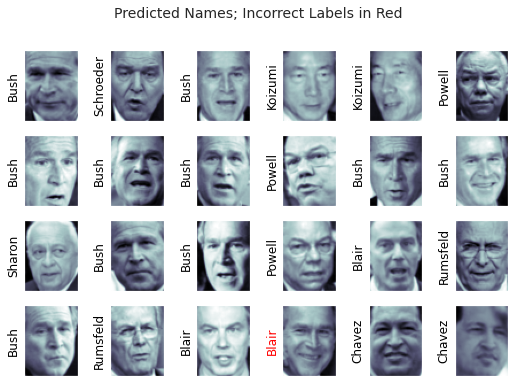

In [8]:
def show_faces(x_test, y_test, y_pred, title, row=4, col=6, h=9, w=6):
  fig, ax = plt.subplots(row, col, figsize=(h, w))
  for i, axi in enumerate(ax.flat):
    axi.imshow(x_test[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[y_pred[i]].split()[-1], color='black' if y_pred[i] == y_test[i] else 'red')
  fig.suptitle(title, size=14)

show_faces(
    x_test=Xtest,
    y_test=ytest, 
    y_pred=yfit,
    title='Predicted Names; Incorrect Labels in Red'
)

In [9]:
from sklearn.metrics import classification_report
# ラベルごとのリカバリ統計情報
print(classification_report(ytest, yfit, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

         accuracy                           0.85       337
        macro avg       0.83      0.84      0.84       337
     weighted avg       0.86      0.85      0.85       337



Text(89.18, 0.5, 'predicted label')

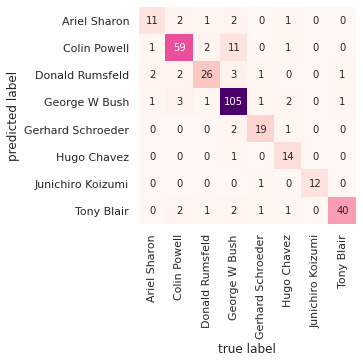

In [10]:
# 混同行列
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T,
            square=True,
            annot=True,
            fmt='d',
            cbar=False,
            cmap='RdPu',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names
)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [11]:
# PCAの結果を見てみる
# pca = PCA(n_components=150, whiten=True, random_state=42, svd_solver='randomized')
pca.fit(faces.data)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=42,
    svd_solver='randomized', tol=0.0, whiten=True)

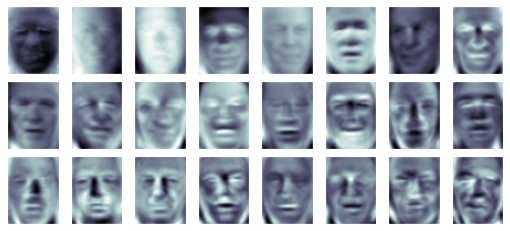

In [14]:
# PCAによる次元削減によって生成された固有顔画像を可視化
def faces_subplots(nrows, ncols, figsize, h=0.1, w=0.1):
  fig, axes = plt.subplots(nrows,
                           ncols,
                           figsize=figsize,
                           subplot_kw={'xticks': [], 'yticks': []},
                           gridspec_kw=dict(hspace=h, wspace=w))
  return fig, axes


fig, axes = faces_subplots(3, 8, (9, 4))
for i, axi in enumerate(axes.flat):
  axi.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

- 最初の5枚あたりまでは、顔の照明の角度が強調されている
- 続く画像では、目、鼻、口などの顔の主要なパーツが強調されている

Text(0, 0.5, 'cumulative explained variance')

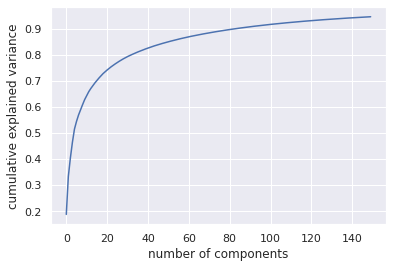

In [15]:
# 累積因子寄与率
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

150に主成分で分散の90%以上がカバーできていることが分かる

In [16]:
# 入力画像とこの150個の主成分から再構成された画像を比較
components = pca.transform(faces.data)
# inverse_transformによって150次元->元の2914次元に逆変換
projected = pca.inverse_transform(components)

Text(0, 0.5, '150-dim\nreconstruction')

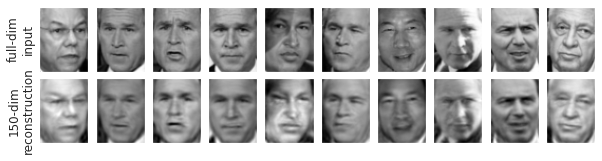

In [17]:
fig, axes = faces_subplots(2, 10, (10, 2.5))
for i in range(10):
  axes[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
  axes[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')

axes[0, 0].set_ylabel('full-dim\ninput')
axes[1, 0].set_ylabel('150-dim\nreconstruction')

元の画像と遜色なく、特徴を反映できていることが分かる

In [19]:
# Isomap
# 非線形多様体埋め込み
from sklearn.manifold import Isomap

model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(1348, 2)

In [24]:
# 2次元投影
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None, thumb_frac=0.05, cmap='gray'):
  ax = ax or plt.gca()

  proj = model.fit_transform(data)
  ax.plot(proj[:, 0], proj[:, 1], '.k')

  if images is not None:
    min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
    shown_images = np.array([2 * proj.max(0)])
    for i in range(data.shape[0]):
      dist = np.sum((proj[i] - shown_images) ** 2, 1)
      if np.min(dist) < min_dist_2:
        # don't show points that are too close
        continue
      shown_images = np.vstack([shown_images, proj[i]])
      imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(images[i], cmap=cmap), proj[i])
      ax.add_artist(imagebox)

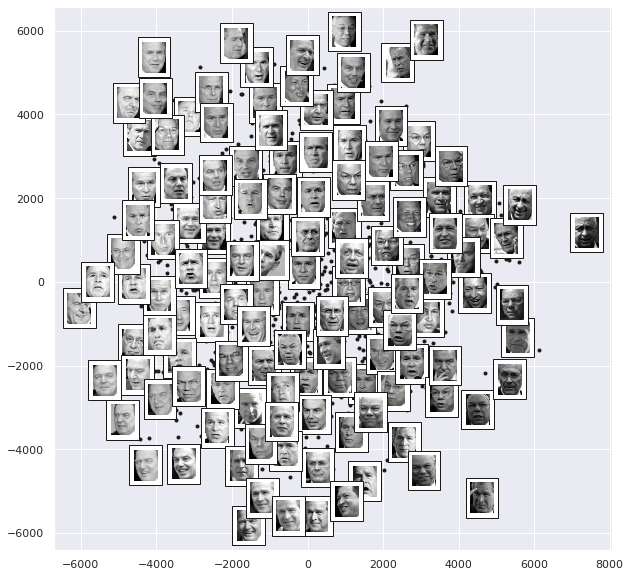

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data, model, images=faces.images[:, ::2, ::2])



*   左から右へ画像全体の明るさの変化を反映しているのが分かる
*   下から上へ顔の向きを反映しているのが分かる

